### Setup

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'whitegrid') 
import plotly.express as px
from datetime import datetime
from IPython.display import clear_output
import os

In [2]:
from data_interaction import select_data_subset, add_lin_reg_prediction, add_price_diff_metric, Company_Data_Getter
from trading_classes import Position, Portfolio
import stock_picking
from stock_picking import best_on_date
import trading_history

In [3]:
base_dir = os.getcwd()
print(base_dir)
file_path = os.path.abspath(os.path.join(base_dir, '..', 'data'))
print(file_path)

c:\Users\matth\codeProjects\union_sif_quant_trading\backtesting
c:\Users\matth\codeProjects\union_sif_quant_trading\data


### Data Preparation

In [4]:
stock_data = pd.read_parquet(file_path+'\\stock_price_data\\all_data_processed_2024-09-28_after_1990.parquet')
display(stock_data.info())
display(stock_data.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8752 entries, 1990-01-02 to 2024-09-27
Columns: 140640 entries, ('Adj_Close', 'AACG') to ('Size_Category', 'ZYXI')
dtypes: float64(134988), int64(30), object(5622)
memory usage: 9.2+ GB


None

Adj_Close                                                        \
                AACG   AACT  AAME    AAN        AAT  ABAT       ABCB  ABCL   
Date                                                                         
2024-09-23      0.63  10.80  1.58  10.06  27.120001  0.89  63.709999  2.48   
2024-09-24      0.68  10.81  1.59  10.06  27.320000  0.87  62.340000  2.52   
2024-09-25      0.73  10.80  1.56  10.03  27.040001  0.81  61.240002  2.44   
2024-09-26      0.72  10.81  1.61  10.03  26.490000  0.94  61.459999  2.56   
2024-09-27      0.73  10.83  1.68  10.05  26.570000  0.98  61.320000  2.61   

                               ... Size_Category                              \
                   ABG   ABTS  ...           ZTS   ZUMZ    ZUO   ZURA   ZVIA   
Date                           ...                                             
2024-09-23  227.949997  0.490  ...         large  small  small  small  micro   
2024-09-24  230.240005  0.500  ...         large  small  small  small  micro   
2024-09-25  231.699997  0.500  ...         large  small  small  micro  micro   
2024-09-26  238.210007  0.499  ...         large  small  small  small  micro   
2024-09-27  244.350006  0.513  ...         large  small  small  small  micro   

                                             
             ZVRA   ZVSA  ZWS   ZYME   ZYXI  
Date                                         
2024-09-23  small  micro  mid  small  small  
2024-09-24  small  micro  mid  small  small  
2024-09-25  small  micro  mid  small  small  
2024-09-26  small  micro  mid  small  small  
2024-09-27  small  micro  mid  small  small  

[5 rows x 140640 columns]

In [5]:
# read company data
company_data = pd.read_csv(file_path+'\\company_data\\company_data_cleaned_2024-09-29.csv',index_col=0)
company_data.head()

Name Last_Sale  \
Ticker                                                                
A                  Agilent Technologies Inc. Common Stock   $148.06   
AA                        Alcoa Corporation Common Stock     $39.27   
AACG     ATA Creativity Global American Depositary Shares   $0.7302   
AACT    Ares Acquisition Corporation II Class A Ordina...  $10.8299   
AADI                    Aadi Bioscience Inc. Common Stock     $1.93   

        Net_Change Percent_Change    Market_Cap        Country  IPO_Year  \
Ticker                                                                     
A           1.3200          0.90%  4.254173e+10  United States    1999.0   
AA         -0.0100        -0.025%  1.014502e+10  United States    2016.0   
AACG        0.0078          1.08%  2.336650e+07          China    2008.0   
AACT        0.0199         0.184%  0.000000e+00            NaN    2023.0   
AADI        0.0200         1.047%  4.750663e+07  United States       NaN   

         Volume       Sector  \
Ticker                         
A       2212993  Industrials   
AA      5629158  Industrials   
AACG      26100  Real Estate   
AACT       2476      Finance   
AADI      81024  Health Care   

                                                Industry Exchange  
Ticker                                                             
A       Biotechnology: Laboratory Analytical Instruments     NYSE  
AA                                              Aluminum     NYSE  
AACG                             Other Consumer Services   NASDAQ  
AACT                                        Blank Checks     NYSE  
AADI          Biotechnology: Pharmaceutical Preparations   NASDAQ

In [6]:
company_data_getter_obj = Company_Data_Getter(stock_data=stock_data,company_data=company_data)

In [7]:
# SPY started trading in january 1993
# Since SPY is our benchmark, we're starting here

stock_data = select_data_subset(
    input_dataframe=stock_data,
    std_dev_day_range=[30, 60],
    reg_day_range=[30, 60],
    # ticker_subset=['AAPL', 'CMI', 'SLB'],
    price_vars_to_exclude=['Open','Close','High','Low'],
    start_date='1993-06-01'
)
display(stock_data.info())
display(stock_data)



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7888 entries, 1993-06-02 to 2024-09-27
Columns: 61319 entries, ('Intercept_60', 'DBRG') to ('Std_Dev_30', 'EVTV')
dtypes: float64(55667), int64(30), object(5622)
memory usage: 3.6+ GB


None

Intercept_60 Std_Dev_30    Market_Cap Size_Category         \
                   DBRG       DERM          FFIC          BIIB   MAXN   
Date                                                                    
1993-06-02          NaN        NaN           NaN         micro   None   
1993-06-03          NaN        NaN           NaN         micro   None   
1993-06-04          NaN        NaN           NaN         micro   None   
1993-06-07          NaN        NaN           NaN         micro   None   
1993-06-08          NaN        NaN           NaN         micro   None   
...                 ...        ...           ...           ...    ...   
2024-09-23   146.985093   0.283169  4.252780e+08         large  micro   
2024-09-24   146.923720   0.287911  4.153946e+08         large  micro   
2024-09-25   146.871148   0.269914  4.084181e+08         large  micro   
2024-09-26   146.819870   0.286450  4.098715e+08         large  micro   
2024-09-27   146.765468   0.302770  4.092901e+08         large  micro   

           Std_Dev_30           Size_Category Intercept_60 Intercept_30  ...  \
                 GIGM      CLAR           PFN         CRTO         TGNA  ...   
Date                                                                     ...   
1993-06-02        NaN       NaN          None          NaN     9.442182  ...   
1993-06-03        NaN       NaN          None          NaN     9.430887  ...   
1993-06-04        NaN       NaN          None          NaN     9.424346  ...   
1993-06-07        NaN       NaN          None          NaN     9.418621  ...   
1993-06-08        NaN       NaN          None          NaN     9.410024  ...   
...               ...       ...           ...          ...          ...  ...   
2024-09-23   0.016452  0.197395         small    20.825669     6.759983  ...   
2024-09-24   0.016879  0.198572         small    20.717192     6.775612  ...   
2024-09-25   0.021158  0.203334         small    20.626358     6.797926  ...   
2024-09-26   0.024813  0.203318         small    20.535777     6.816398  ...   
2024-09-27   0.026392  0.203082         small    20.517366     6.846262  ...   

           Size_Category    Volume               Market_Cap  \
                    LEVI      BOOT       AQST           CHE   
Date                                                          
1993-06-02          None       NaN        NaN  7.742583e+07   
1993-06-03          None       NaN        NaN  7.742583e+07   
1993-06-04          None       NaN        NaN  7.809045e+07   
1993-06-07          None       NaN        NaN  7.842274e+07   
1993-06-08          None       NaN        NaN  7.775819e+07   
...                  ...       ...        ...           ...   
2024-09-23           mid  582600.0  1314900.0  8.836372e+09   
2024-09-24           mid  274500.0   899000.0  8.900401e+09   
2024-09-25           mid  543800.0  1113100.0  8.930691e+09   
2024-09-26           mid  389600.0   976600.0  8.998020e+09   
2024-09-27           mid  446200.0  2659200.0  8.982724e+09   

           Dates_Numeric_Coeff_60 Dates_Numeric_Coeff_30 Adj_Close Std_Dev_30  \
                              IGR                   TBRG      NKLA       DELL   
Date                                                                            
1993-06-02                    NaN                    NaN       NaN        NaN   
1993-06-03                    NaN                    NaN       NaN        NaN   
1993-06-04                    NaN                    NaN       NaN        NaN   
1993-06-07                    NaN                    NaN       NaN        NaN   
1993-06-08                    NaN                    NaN       NaN        NaN   
...                           ...                    ...       ...        ...   
2024-09-23               0.000419              -0.000885      4.78   5.990289   
2024-09-24               0.000422              -0.000886      4.68   5.249150   
2024-09-25               0.000425              -0.000889      4.32   4.568430   
2024-09-26  

In [8]:
pred_df_30 = add_lin_reg_prediction(stock_data, 30, new_multiindex_col_name='Lin_Reg_30_Pred_0')
pred_df_60 = add_lin_reg_prediction(stock_data, 60, new_multiindex_col_name='Lin_Reg_60_Pred_0')

stock_data = pd.concat([stock_data, pred_df_30, pred_df_60],axis=1)

stock_data = pd.concat([ stock_data, 
                           add_price_diff_metric(stock_data, 'Adj_Close','Lin_Reg_60_Pred_0', 'Std_Dev_30', 'delta_60pred_by_30std')
                           ], axis=1)

# adds volume value
price_df = stock_data.xs('Adj_Close',axis=1,level=0)
volume_df = stock_data.xs('Volume',axis=1,level=0)
volume_value_df = price_df*volume_df
new_columns = pd.MultiIndex.from_product([['Volume_Value'], volume_value_df.columns])
volume_value_df.columns = new_columns
# display(volume_value_df)
stock_data = pd.concat([stock_data,volume_value_df],axis=1)
print(list({x[0] for x in stock_data.columns}))
display(stock_data.info())
display(stock_data)



['delta_60pred_by_30std', 'Market_Cap', 'Intercept_60', 'Volume', 'Dates_Numeric', 'Lin_Reg_60_Pred_0', 'Std_Dev_60', 'Volume_Value', 'Lin_Reg_30_Pred_0', 'Intercept_30', 'Dates_Numeric_Coeff_60', 'Std_Dev_30', 'Dates_Numeric_Coeff_30', 'Adj_Close', 'Size_Category']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7888 entries, 1993-06-02 to 2024-09-27
Columns: 85977 entries, ('Intercept_60', 'DBRG') to ('Volume_Value', 'ZYXI')
dtypes: float64(80325), int64(30), object(5622)
memory usage: 5.1+ GB


None

Intercept_60 Std_Dev_30    Market_Cap Size_Category         \
                   DBRG       DERM          FFIC          BIIB   MAXN   
Date                                                                    
1993-06-02          NaN        NaN           NaN         micro   None   
1993-06-03          NaN        NaN           NaN         micro   None   
1993-06-04          NaN        NaN           NaN         micro   None   
1993-06-07          NaN        NaN           NaN         micro   None   
1993-06-08          NaN        NaN           NaN         micro   None   
...                 ...        ...           ...           ...    ...   
2024-09-23   146.985093   0.283169  4.252780e+08         large  micro   
2024-09-24   146.923720   0.287911  4.153946e+08         large  micro   
2024-09-25   146.871148   0.269914  4.084181e+08         large  micro   
2024-09-26   146.819870   0.286450  4.098715e+08         large  micro   
2024-09-27   146.765468   0.302770  4.092901e+08         large  micro   

           Std_Dev_30           Size_Category Intercept_60 Intercept_30  ...  \
                 GIGM      CLAR           PFN         CRTO         TGNA  ...   
Date                                                                     ...   
1993-06-02        NaN       NaN          None          NaN     9.442182  ...   
1993-06-03        NaN       NaN          None          NaN     9.430887  ...   
1993-06-04        NaN       NaN          None          NaN     9.424346  ...   
1993-06-07        NaN       NaN          None          NaN     9.418621  ...   
1993-06-08        NaN       NaN          None          NaN     9.410024  ...   
...               ...       ...           ...          ...          ...  ...   
2024-09-23   0.016452  0.197395         small    20.825669     6.759983  ...   
2024-09-24   0.016879  0.198572         small    20.717192     6.775612  ...   
2024-09-25   0.021158  0.203334         small    20.626358     6.797926  ...   
2024-09-26   0.024813  0.203318         small    20.535777     6.816398  ...   
2024-09-27   0.026392  0.203082         small    20.517366     6.846262  ...   

            Volume_Value                                            \
                     ZTS          ZUMZ           ZUO          ZURA   
Date                                                                 
1993-06-02           NaN           NaN           NaN           NaN   
1993-06-03           NaN           NaN           NaN           NaN   
1993-06-04           NaN           NaN           NaN           NaN   
1993-06-07           NaN           NaN           NaN           NaN   
1993-06-08           NaN           NaN           NaN           NaN   
...                  ...           ...           ...           ...   
2024-09-23  2.547064e+08  7.684122e+06  9.765792e+06  5.381460e+06   
2024-09-24  3.961154e+08  5.761600e+06  6.546320e+06  1.614000e+06   
2024-09-25  3.651136e+08  5.397345e+06  9.717246e+06  7.163120e+05   
2024-09-26  3.032372e+08  5.384998e+06  8.135578e+06  7.189670e+05   
2024-09-27  2.617662e+08  5.775000e+06  1.135437e+07  1.600731e+06   

                                                                      \
                     ZVIA          ZVRA           ZVSA           ZWS   
Date                                                                   
1993-06-02            NaN           NaN            NaN           NaN   
1993-06-03            NaN           NaN            NaN           NaN   
1993-06-04            NaN           NaN            NaN           NaN   
1993-06-07            NaN           NaN            NaN           NaN   
1993-06-08            NaN           NaN            NaN           NaN   
...                   ...           ...            ...           ...   
2024-09-23  121220.002627  1.818669e+07   92232.003665  5.164454e+07   
2024-09-24  130540.006399  2.047156e+07   73365.001917  3.427823e+07   
2024-09-25  330747.005129  1.784845e+07   82287.000704  3.541829e+07   
2024-09-26  176903.993

### Trading Simulation

In [1409]:
list_of_dates = stock_data.index
list_of_dates

DatetimeIndex(['1993-06-02', '1993-06-03', '1993-06-04', '1993-06-07',
               '1993-06-08', '1993-06-09', '1993-06-10', '1993-06-11',
               '1993-06-14', '1993-06-15',
               ...
               '2024-09-16', '2024-09-17', '2024-09-18', '2024-09-19',
               '2024-09-20', '2024-09-23', '2024-09-24', '2024-09-25',
               '2024-09-26', '2024-09-27'],
              dtype='datetime64[ns]', name='Date', length=7888, freq=None)

In [1410]:
# start_date = '2021-01-01'
start_date = '2003-01-01'
# end_date = '2021-03-01'
theo_var = 'Lin_Reg_60_Pred_0'
std_dev_var = 'Std_Dev_30'
price_diff_var = 'delta_60pred_by_30std'
too_old_days = 366
how_many_poss = 50

common_stop_loss =  0.25 # new
common_take_profit = 5 # new
mean_reversion_take_profit = common_take_profit
momentum_take_profit = common_take_profit
# mean_reversion_take_profit = 'initial_theo'
limiting_trading_volume = False #SHOULD BE TRUE, 


In [1411]:
list_of_dates = list_of_dates[list_of_dates>=start_date]
# list_of_dates = list_of_dates[list_of_dates<=end_date]
last_date = list_of_dates[-1]
first_date = list_of_dates[0]
list_of_dates


DatetimeIndex(['2003-01-02', '2003-01-03', '2003-01-06', '2003-01-07',
               '2003-01-08', '2003-01-09', '2003-01-10', '2003-01-13',
               '2003-01-14', '2003-01-15',
               ...
               '2024-09-16', '2024-09-17', '2024-09-18', '2024-09-19',
               '2024-09-20', '2024-09-23', '2024-09-24', '2024-09-25',
               '2024-09-26', '2024-09-27'],
              dtype='datetime64[ns]', name='Date', length=5472, freq=None)

In [1412]:
# reloads locally imported libraries (only necessary if changes have been made in the libraries and we don't want to rerun the above code)
import importlib
import trading_classes
importlib.reload(trading_classes)
from trading_classes import Position, Portfolio


importlib.reload(trading_history)
from trading_history import Trading_History

importlib.reload(stock_picking)
from stock_picking import best_on_date

In [1413]:
trading_history_obj = Trading_History(stock_data, company_data)

In [1414]:
portfolio_starting_capital = 5_000_000


momentum_portfolio = Portfolio(portfolio_starting_capital, list_of_dates[0], stock_data,
                         theo_var, std_dev_var, price_diff_var,company_data=company_data, trading_history_obj=trading_history_obj,
                         portfolio_name='momentum_portfolio', stop_loss_threshold=common_stop_loss, take_profit_threshold=momentum_take_profit)

mean_reversion_portfolio = Portfolio(portfolio_starting_capital, list_of_dates[0], stock_data,
                         theo_var, std_dev_var, price_diff_var,company_data=company_data, trading_history_obj=trading_history_obj,
                         portfolio_name='mean_reversion_portfolio', stop_loss_threshold=common_stop_loss, take_profit_threshold=mean_reversion_take_profit)

side_portfolio = Portfolio(portfolio_starting_capital, list_of_dates[0], stock_data,
                         theo_var, std_dev_var, price_diff_var,company_data=company_data, trading_history_obj=trading_history_obj,
                         portfolio_name='side_portfolio', stop_loss_threshold=common_stop_loss, take_profit_threshold=common_take_profit)

# vol_portfolio = Portfolio(portfolio_starting_capital, list_of_dates[0], stock_data,
#                           theo_var, std_dev_var,price_diff_var,company_data=company_data, trading_history_obj=trading_history_obj,
#                           portfolio_name='volatility_portfolio', stop_loss_threshold=common_stop_loss, take_profit_threshold=common_take_profit)

portfolio_list = [momentum_portfolio,mean_reversion_portfolio,side_portfolio]
for portfolio in portfolio_list:
    print(portfolio)

momentum_portfolio:
Current Portfolio Value: 5000000.0
Cash: 5000000.0

2003-01-02 00:00:00
mean_reversion_portfolio:
Current Portfolio Value: 5000000.0
Cash: 5000000.0

2003-01-02 00:00:00
side_portfolio:
Current Portfolio Value: 5000000.0
Cash: 5000000.0

2003-01-02 00:00:00


In [1415]:
print(f"std_dev_var: {std_dev_var}")
print(f"theo_var: {theo_var}")
print(f"price_diff_var: {price_diff_var}")
print(f"too_old_days: {too_old_days}")
print(f"how_many_poss: {how_many_poss}")

std_dev_var: Std_Dev_30
theo_var: Lin_Reg_60_Pred_0
price_diff_var: delta_60pred_by_30std
too_old_days: 366
how_many_poss: 50


In [1416]:
historical_performance = pd.DataFrame(columns=['Portfolio_Value'])
historical_performance.index.name = 'Date'

In [1417]:
# stock_data.xs('Size_Category',1,0).stack().value_counts()

In [1418]:
how_many_poss = how_many_poss

In [1419]:
#run this to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [1420]:
# positions_we_want = best_on_date(stock_data=stock_data_date_slice,date=date,metric=price_diff_var,date_already_xs_unstack_transposed=True,abs_val=abs_val_arg,how_many=how_many_poss,
#                                              max_or_min=min_or_max_arg, extreme_filter_value=extreme_limit, max_share_price=position_size,size_categories=['mid','large','mega'], min_market_cap=50_000_000,
#                                              avoid_sectors_filter=bad_sectors,avoid_industries_filter=bad_industries,company_data_getter_obj=company_data_getter_obj)

In [1421]:
# print(positions_we_want)

In [1422]:
# (list_of_dates[1000]).days

In [1423]:
short_position_wiggle_room = 0.05
for date in list_of_dates:
    days_old = (date - first_date).days
    if days_old!=0 and days_old%15==0:
        info_string = f'_________\n{date.date()}\n'
        for portfolio in portfolio_list:
            info_string += portfolio.portfolio_name + ' Annualized Return: ' + '{:,.2f}%'.format(float(((portfolio.get_portfolio_value(date)/portfolio_starting_capital)**(365/days_old)-1)*100)) + '%\n'
            info_string += portfolio.portfolio_name + ' value: ' + '${:,.2f}'.format(float(portfolio.get_portfolio_value(date))) + '\n'
        info_string += '____________________________________'
        print(info_string)

    # clear_output(wait=True)

    for portfolio in portfolio_list:
        #keep track of portfolio value day by day

        portfolio.refresh_position_df(date)
        # any positions to sell
        positions_names_to_sell = portfolio.positions_to_close(date)
        if len(positions_names_to_sell) > 0:
            # print(f'_________\n{date.date()}')
            # print(f"Annualized Returns: {((portfolio.get_portfolio_value(date)/portfolio_starting_capital)**(365/days_old)-1)*100}%")
            # print(f"{portfolio.portfolio_name} value: {portfolio.get_portfolio_value(date)}")
            # print(f"Positions have vs desired: {portfolio.position_count()} vs {how_many_poss}")
            # print(f"{portfolio.portfolio_name} cash on hand: {portfolio.get_cash()}")
            # print(f"{portfolio.portfolio_name} positions_names_to_sell: {positions_names_to_sell}")
            # print(f"Position Size: {position_size}")

            portfolio.close_positions(positions_names_to_sell,date)
        
        bad_sectors = None
        bad_industries = None

        # buy new positions
        if(portfolio.position_count()<how_many_poss):
            # stock_data_date_slice = stock_data.xs(date).unstack().transpose() # used to be uncommented
            if portfolio.portfolio_name=='momentum_portfolio':
                min_or_max_arg = 'min'  # UNSWAPPED
                abs_val_arg = False # SWAPPED
                extreme_limit = None # used to be 10
                # bad_sectors = ['Finance', 'Consumer Discretionary', 'Technology', 'Energy', 'Utilities', 'Telecommunications', 'Miscellaneous','']
                # bad_sectors=['Miscellaneous','Energy','Real Estate','Health Care', 'Utilities']
                # bad_industries = ['Advertising','Telecommunications Equipment','Electric Utilities: Central','Apparel','Commercial Banks']
                strategy_name = 'Momentum'
            elif portfolio.portfolio_name=='mean_reversion_portfolio':
                min_or_max_arg='max'  # UNSWAPPED
                abs_val_arg = False # SWAPPED
                extreme_limit= None # used to be 10
                # bad_sectors = ['Consumer Discretionary', 'Technology', 'Energy', 'Utilities', 'Consumer Staples', 'Basic Materials', 'Miscellaneous','']\
                # bad_sectors = ['Miscellaneous','Energy','Real Estate','Telecommunications']
                # bad_industries = ['Biotechnology: Pharmaceutical Preparations','Finance: Consumer Services','Commercial Banks','']
                # bad_industries = ['Apparel','Recreational Games/Products/Toys']
                strategy_name = 'Mean_Reversion'
            elif portfolio.portfolio_name=='side_portfolio':
                min_or_max_arg = 'min'
                abs_val_arg = True
                extreme_limit=None # used to be 10
                # bad_sectors=['Miscellaneous']
                # bad_industries = []
                # bad_sectors = ['Finance', 'Consumer Discretionary', 'Technology', 'Industrials', 'Real Estate', 'Energy', 'Utilities', 'Consumer Staples', 'Telecommunications', 'Basic Materials', 'Miscellaneous','']
                strategy_name='Side'
            
            position_size = portfolio.get_cash()*(1-short_position_wiggle_room)/(how_many_poss-portfolio.position_count())
            
            # # positions_we_want = best_on_date(stock_data=stock_data_date_slice,date=date,metric=price_diff_var,date_already_xs_unstack_transposed=True,abs_val=abs_val_arg,how_many=how_many_poss,
            # #                                  max_or_min=min_or_max_arg, extreme_filter_value=extreme_limit, max_share_price=position_size,size_categories=['mid','large','mega'], min_market_cap=50_000_000,
            # #                                  avoid_sectors_filter=bad_sectors,avoid_industries_filter=bad_industries,company_data_getter_obj=company_data_getter_obj)
            # print(position_size)
            positions_we_want = best_on_date(stock_data=stock_data,date=date,metric=price_diff_var,date_already_xs_unstack_transposed=False,abs_val=abs_val_arg,how_many=how_many_poss - portfolio.position_count(),
                                             max_or_min=min_or_max_arg, extreme_filter_value=extreme_limit, max_share_price=position_size,size_categories=['mid','large','mega'], min_market_cap=50_000_000,
                                             avoid_sectors_filter=bad_sectors,avoid_industries_filter=bad_industries,company_data_getter_obj=company_data_getter_obj)

            # print(f"positions_we_want{positions_we_want}")

            # print(f"{portfolio.portfolio_name} value: {portfolio.get_portfolio_value(date)}")

            # open positions
            # get data on the positions we want
            relevant_data = stock_data.xs(date).unstack().transpose().loc[positions_we_want,['Adj_Close','Market_Cap','Size_Category',price_diff_var,std_dev_var,theo_var,'Volume','Volume_Value']]
            
            relevant_data['Strategy'] = strategy_name


            for ticker in positions_we_want:
                # last part makes desired shares negative if we expect stock to go down
                    # *1.03 gives us wiggle room for slippage


                if relevant_data.loc[ticker,'Strategy']=='Mean_Reversion':
                    desired_shares = (position_size//(relevant_data.at[ticker,'Adj_Close']*1.03)) * (relevant_data.loc[ticker, price_diff_var]/abs(relevant_data.loc[ticker, price_diff_var]))
                    if desired_shares == 0:
                        pass
                    relevant_data.loc[ticker,'Desired_Shares'] = (position_size//(relevant_data.at[ticker,'Adj_Close']*1.03)) * (relevant_data.loc[ticker, price_diff_var]/abs(relevant_data.loc[ticker, price_diff_var]))
                    # make sure we're not trading more than 3% of the trading volume 
                    relevant_data['Desired_Shares'] = np.minimum(abs(relevant_data['Desired_Shares']), 0.08 * relevant_data['Volume']) * (relevant_data['Desired_Shares']/abs(relevant_data['Desired_Shares'])) # last part accounts for shorting

                    # make it momentum instead of mean reversion
                    '''relevant_data.loc[ticker,'Desired_Shares'] *= -1    # SWAPPED'''
                    # if relevant_data.loc[ticker,'Desired_Shares'] <0:
                    #     relevant_data.loc[ticker,'Desired_Shares'] *= -1
                    # relevant_data.loc[ticker,'Desired_Shares'] *= -1
                    relevant_data['Desired_Shares'] = relevant_data['Desired_Shares'].fillna(0)


                    # historical_trades.loc[date] = [tts, my_portfolio.position_df.loc[tts,'Exposure'], my_portfolio.position_df.loc[tts,'Position'].get_current_value(date),None]
                    portfolio.open_position(date,ticker, relevant_data.at[ticker,'Desired_Shares'],indicator=relevant_data.at[ticker,price_diff_var])

                
                if relevant_data.loc[ticker,'Strategy']=='Momentum':
                    desired_shares = (position_size//(relevant_data.at[ticker,'Adj_Close']*1.03)) * (relevant_data.loc[ticker, price_diff_var]/abs(relevant_data.loc[ticker, price_diff_var]))
                    if desired_shares == 0:
                        pass
                    relevant_data.loc[ticker,'Desired_Shares'] = (position_size//(relevant_data.at[ticker,'Adj_Close']*1.03)) * (relevant_data.loc[ticker, price_diff_var]/abs(relevant_data.loc[ticker, price_diff_var]))
                    # make sure we're not trading more than 3% of the trading volume 
                    if limiting_trading_volume:
                        relevant_data['Desired_Shares'] = np.minimum(abs(relevant_data['Desired_Shares']), 0.08 * relevant_data['Volume']) * (relevant_data['Desired_Shares']/abs(relevant_data['Desired_Shares'])) # last part accounts for shorting

                    # make it momentum instead of mean reversion
                    '''# relevant_data.loc[ticker,'Desired_Shares'] *= -1  # SWAPPED'''
                    # if relevant_data.loc[ticker,'Desired_Shares'] <0:
                    #     relevant_data.loc[ticker,'Desired_Shares'] *= -1
                    relevant_data.loc[ticker,'Desired_Shares'] *= -1
                    relevant_data['Desired_Shares'] = relevant_data['Desired_Shares'].fillna(0)


                    # historical_trades.loc[date] = [tts, my_portfolio.position_df.loc[tts,'Exposure'], my_portfolio.position_df.loc[tts,'Position'].get_current_value(date),None]
                    portfolio.open_position(date,ticker, relevant_data.at[ticker,'Desired_Shares'], indicator=relevant_data.at[ticker,price_diff_var])


                if relevant_data.loc[ticker,'Strategy']=='Side':
                    desired_shares = (position_size//(relevant_data.at[ticker,'Adj_Close']*1.03)) * (relevant_data.loc[ticker, price_diff_var]/abs(relevant_data.loc[ticker, price_diff_var]))
                    if desired_shares == 0:
                        pass
                    relevant_data.loc[ticker,'Desired_Shares'] = (position_size//(relevant_data.at[ticker,'Adj_Close']*1.03)) * (relevant_data.loc[ticker, price_diff_var]/abs(relevant_data.loc[ticker, price_diff_var]))
                    # make sure we're not trading more than 3% of the trading volume 
                    relevant_data['Desired_Shares'] = np.minimum(abs(relevant_data['Desired_Shares']), 0.08 * relevant_data['Volume']) * (relevant_data['Desired_Shares']/abs(relevant_data['Desired_Shares'])) # last part accounts for shorting

                    # make it momentum instead of mean reversion
                    '''# relevant_data.loc[ticker,'Desired_Shares'] *= -1  # SWAPPED'''
                    if relevant_data.loc[ticker,'Desired_Shares'] <0:
                        relevant_data.loc[ticker,'Desired_Shares'] *= -1
                    relevant_data['Desired_Shares'] = relevant_data['Desired_Shares'].fillna(0)


                    # historical_trades.loc[date] = [tts, my_portfolio.position_df.loc[tts,'Exposure'], my_portfolio.position_df.loc[tts,'Position'].get_current_value(date),None]
                    portfolio.open_position(date,ticker, relevant_data.at[ticker,'Desired_Shares'], indicator=relevant_data.at[ticker,price_diff_var])
        # if it's the last day, sell everything
        if date == last_date:
            # sell all positions from all portfolios at the end of simulation
            portoflio_poss = portfolio.position_df.index.drop('cash_position')############============##########
            portfolio.close_positions(portoflio_poss,last_date)
            print(portfolio)
        # take snapshot after trades
        portfolio.add_value_snapshot(date)
    clear_output(wait=True)

        # display(relevant_data)
        # print(date)
    # historical_performance.loc[date] = my_portfolio.get_portfolio_value(date)
        
    # desired_shares = my_portfolio.cash/2//relevant_data.at['JBHT','Adj_Close']
    # my_portfolio.open_position(Position(date,'JBHT',desired_shares))


momentum_portfolio:
Current Portfolio Value: 3753973.0025737956
Cash: 3753973.0025737956

2024-09-27 00:00:00
mean_reversion_portfolio:
Current Portfolio Value: 45945988.59644085
Cash: 45945988.59644085

2024-09-27 00:00:00
side_portfolio:
Current Portfolio Value: 41406022.965391986
Cash: 41406022.965391986

2024-09-27 00:00:00


### Performance Analysis

In [1424]:
spy_data = yf.download('SPY', start=list_of_dates[0],end=list_of_dates[-1])
spy_data = spy_data.xs('SPY',axis=1,level=1)
spy_data.index=spy_data.index.tz_convert(None)
spy_data.rename(columns = {'Adj Close':'SPY_Adj_Close'},inplace=True)


spy_data_adj_close = spy_data.loc[:,['SPY_Adj_Close']]
spy_data_adj_close = (spy_data_adj_close.loc[:,['SPY_Adj_Close']]/spy_data_adj_close.iat[0,0]) * portfolio_starting_capital

[*********************100%***********************]  1 of 1 completed


In [1425]:
historical_performance_benchmark = spy_data_adj_close.dropna()
for portfolio in portfolio_list:
    port_hist_perf = portfolio.historical_performance.copy()
    # port_hist_perf.index = port_hist_perf['Date']
    # port_hist_perf.index.name = 'Date'
    # port_hist_perf = port_hist_perf.drop('Date',axis=1)
    historical_performance_benchmark = pd.concat([historical_performance_benchmark,port_hist_perf.dropna()],axis=1)

In [1426]:
px.line(data_frame=historical_performance_benchmark.loc[:,['momentum_portfolio','mean_reversion_portfolio','side_portfolio','SPY_Adj_Close']],log_y=True)

In [1427]:
pd.set_option('display.max_columns',50)

In [1472]:
import performance_analytics
importlib.reload(performance_analytics)
from performance_analytics import make_stats_dataframe, make_mulit_stats_dataframe
pd.set_option('display.max_rows',250)


In [1473]:
historical_performance_benchmark['momentum_portfolio_returns'] = historical_performance_benchmark['momentum_portfolio'].pct_change()
historical_performance_benchmark['mean_reversion_portfolio_returns'] = historical_performance_benchmark['mean_reversion_portfolio'].pct_change()
historical_performance_benchmark['side_portfolio_returns'] = historical_performance_benchmark['side_portfolio'].pct_change()

historical_performance_benchmark['SPY_Returns'] = historical_performance_benchmark['SPY_Adj_Close'].pct_change()
# display(historical_performance_benchmark)

In [1474]:
make_mulit_stats_dataframe(historical_performance_benchmark,'SPY_Returns',['momentum_portfolio_returns','mean_reversion_portfolio_returns','side_portfolio_returns'])

Annualized Return (CAGR)  \
Portfolio_Name                                               
side_portfolio_returns                               6.954   
mean_reversion_portfolio_returns                     7.308   
momentum_portfolio_returns                          -0.893   
SPY_Returns                                          7.391   

                                  Volatility (Standard Deviation)  \
Portfolio_Name                                                      
side_portfolio_returns                                     21.187   
mean_reversion_portfolio_returns                           25.954   
momentum_portfolio_returns                                 38.723   
SPY_Returns                                                18.688   

                                  Max Drawdown  Alpha   Beta  Sharpe Ratio  \
Portfolio_Name                                                               
side_portfolio_returns                 -62.973 -0.003  1.021         0.567   
mean_reversion_portfolio_returns       -60.773  0.007  1.065         0.524   
momentum_portfolio_returns             -88.890 -0.055  0.908         0.141   
SPY_Returns                            -55.189  0.000  1.000         0.647   

                                  Sortino Ratio  
Portfolio_Name                                   
side_portfolio_returns                    0.791  
mean_reversion_portfolio_returns          0.764  
momentum_portfolio_returns                0.246  
SPY_Returns                               0.913

### Trading Analysis

In [1475]:
# from data_interaction import str_to_date_obj

In [1476]:
trading_history_obj.add_analytics()
display(trading_history_obj.trades.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
Index: 3399 entries, MT_2003-01-02 to HCP_2024-09-23
Columns: 34 entries, Ticker to Above_Even
dtypes: bool(1), datetime64[ns](2), float64(5), int64(3), object(23)
memory usage: 1.0+ MB


None

In [1477]:
# number of shares in trades-- basically checking that wer're not accidentally shorting stuff since we wanna be long only
px.histogram(data_frame=trading_history_obj.trades,x='Shares',facet_col='Portfolio')

In [1478]:
historical_performance_benchmark_just_returns = historical_performance_benchmark.loc[:,['SPY_Returns','momentum_portfolio_returns','mean_reversion_portfolio_returns','side_portfolio_returns']]

In [1479]:
# trading_history_obj.trades = trading_history_obj.trades.assign(above_even=(lambda x: x>1)(trading_history_obj.trades.Annualized_Percent_Return))
trading_history_obj.trades.sample(5)

Ticker Entry_Date  Entry_Share_Price  Entry_Trading_Cost  \
GATX_2020-01-24   GATX 2020-01-24          77.367828               0.005   
SNDL_2020-01-24   SNDL 2020-01-24          26.299999               0.005   
PLUG_2015-01-16   PLUG 2015-01-16           2.670000               0.005   
NOG_2015-01-16     NOG 2015-01-16          63.133507               0.005   
ALKS_2016-03-07   ALKS 2016-03-07          33.930000               0.005   

                   Shares  Exit_Date Exit_Share_Price Exit_Trading_Cost  \
GATX_2020-01-24    2745.0 2021-01-25        87.049568             0.005   
SNDL_2020-01-24    5900.0 2020-03-18              6.1              0.01   
PLUG_2015-01-16   66421.0 2016-01-19             1.53              0.01   
NOG_2015-01-16     4417.0 2016-01-19        25.233612             0.005   
ALKS_2016-03-07  170880.0 2017-03-08        57.400002             0.005   

                 Indicator High_Water_Share_Price High_Water_Date  \
GATX_2020-01-24   0.090490          212374.688873      2020-01-24   
SNDL_2020-01-24  -4.269082          155169.995499      2020-01-24   
PLUG_2015-01-16  -8.809701          177344.075068      2015-01-16   
NOG_2015-01-16    4.729605          278860.699425      2015-01-16   
ALKS_2016-03-07  10.840600         5797958.452148      2016-03-07   

                Low_Water_Share_Price Low_Water_Date  \
GATX_2020-01-24             50.595329     2020-04-20   
SNDL_2020-01-24                   6.1     2020-03-18   
PLUG_2015-01-16                  1.53     2016-01-19   
NOG_2015-01-16              25.233612     2016-01-19   
ALKS_2016-03-07             29.049999     2016-03-16   

                                Portfolio  Days_Held          Return  \
GATX_2020-01-24            side_portfolio        367    26576.375771   
SNDL_2020-01-24        momentum_portfolio         54  -119179.996061   
PLUG_2015-01-16        momentum_portfolio        368   -75719.946968   
NOG_2015-01-16   mean_reversion_portfolio        368  -167403.834953   
ALKS_2016-03-07  mean_reversion_portfolio        366  4010553.808594   

                Percent_Return Annualized_Percent_Return    High_Water_Return  \
GATX_2020-01-24       0.125139                  0.124416     582756146.268311   
SNDL_2020-01-24      -0.768061                 -0.999949     915347803.446579   
PLUG_2015-01-16      -0.426966                 -0.424359   11779193465.984688   
NOG_2015-01-16       -0.600313                 -0.597314    1231448848.659668   
ALKS_2016-03-07       0.691718                   0.68929  990749342344.672852   

                High_Water_Percent_Return  High_Water_Days_After_Purchase  \
GATX_2020-01-24                  2730.275                               0   
SNDL_2020-01-24                    5840.0                               0   
PLUG_2015-01-16                  65755.79                               0   
NOG_2015-01-16                   4393.915                               0   
ALKS_2016-03-07                  170024.6                               0   

                High_Water_Annualized_Percent_Return low_Water_Return  \
GATX_2020-01-24                                  inf    -73490.509987   
SNDL_2020-01-24                                  inf   -119179.996061   
PLUG_2015-01-16                                  inf    -75719.946968   
NOG_2015-01-16                                   inf   -167403.834953   
ALKS_2016-03-07                                  inf    -833894.58252   

                Low_Water_Percent_Return  Low_Water_Days_After_Purchase  \
GATX_2020-01-24                -0.349312                             87   
SNDL_2020-01-24                 -0.77038                             54   
PLUG_2015-01-16                -0.432697                            368   
NOG_2015-01-16                 -0.602312                            368   
ALKS_2016-03-07                -0.148106                              9   

                Low_Water_Annualized_Percent_Return  \
GATX_2020-01-24             

In [1480]:
pd.set_option('display.max_rows',400)
display(
        trading_history_obj.trades.groupby(['Portfolio', 'Sector']).agg({
        'Annualized_Percent_Return': ['count', 'mean','min','max','std'],
        'Percent_Return': ['mean','min','max','std'],
        'Return': ['sum','min','max','std']
    }).reset_index().sort_values(
        by=['Portfolio', ('Percent_Return', 'mean')], 
        ascending=[True, False]
    ).set_index(['Portfolio','Sector'])
    # .query("'(Percent_Return, mean)' >= 5")
    )

pd.reset_option('display.max_rows')


Annualized_Percent_Return  \
                                                                    count   
Portfolio                Sector                                             
mean_reversion_portfolio Industrials                                   94   
                         Consumer Discretionary                       237   
                         Technology                                   128   
                         Utilities                                     70   
                         Consumer Staples                              68   
                         Telecommunications                            41   
                         Basic Materials                               40   
                         Real Estate                                   57   
                         Health Care                                  164   
                         Finance                                      158   
                         Energy                                        61   
                         Miscellaneous                                  8   
momentum_portfolio       Miscellaneous                                  2   
                         Basic Materials                               26   
                         Telecommunications                            44   
                         Utilities                                     60   
                         Real Estate                                   78   
                         Finance                                      162   
                         Technology                                   131   
                         Consumer Discretionary                       196   
                         Consumer Staples                              36   
                         Industrials                                  130   
                         Health Care                                  234   
                         Energy                                        58   
side_portfolio           Technology                                   146   
                         Telecommunications                            37   
                         Utilities                                     82   
                         Health Care                                  116   
                         Real Estate                                   90   
                         Industrials                                  132   
                         Finance                                      170   
                         Consumer Discretionary                       192   
                         Consumer Staples                              45   
                         Energy                                        56   
                         Basic Materials                               31   
                         Miscellaneous                                  5   

                                                                                 \
                                                                           mean   
Portfolio                Sector                                                   
mean_reversion_portfolio Industrials                                   0.165829   
                         Consumer Discretionary                        0.220483   
                         Technology                                    5.676811   
                         Utilities                                     0.113992   
                         Consumer Staples                                0.1189   
                         Telecommunications                            0.112813   
                         Basic Materials                               0.080474   
                         Real Estate                                   0.062413   
                         Health Care                                    0.08165   
                         Finance                

In [1481]:
pd.set_option('display.max_rows',400)
display(
        trading_history_obj.trades.groupby(['Portfolio', 'Sector','Industry']).agg({
        'Annualized_Percent_Return': ['count', 'mean','min','max'],
        'Percent_Return': ['mean','min','max'],
        'Return': ['sum','min','max']
    }).reset_index().sort_values(
        by=['Portfolio', ('Percent_Return', 'mean')], 
        ascending=[True, False]
    ).set_index(['Portfolio','Sector', 'Industry'])
    # .query("'(Percent_Return, mean)' >= 5")
    )

pd.reset_option('display.max_rows')


Annualized_Percent_Return  \
                                                                                                                   count   
Portfolio                Sector                 Industry                                                                   
mean_reversion_portfolio Consumer Discretionary Broadcasting                                                           1   
                         Technology             Computer Software: Programming Data Processing                        11   
                         Industrials            Aluminum                                                               3   
                         Utilities              Natural Gas Distribution                                               6   
                         Energy                 Coal Mining                                                            1   
...                                                                                                                  ...   
side_portfolio           Industrials            Ordnance And Accessories                                               1   
                         Miscellaneous          Industrial Machinery/Components                                        3   
                         Real Estate            Homebuilding                                                           1   
                         Consumer Discretionary Movies/Entertainment                                                   1   
                                                Rental/Leasing Companies                                               1   

                                                                                                           \
                                                                                                     mean   
Portfolio                Sector                 Industry                                                    
mean_reversion_portfolio Consumer Discretionary Broadcasting                                     4.227489   
                         Technology             Computer Software: Programming Data Processing  57.561845   
                         Industrials            Aluminum                                         0.978946   
                         Utilities              Natural Gas Distribution                         0.904144   
                         Energy                 Coal Mining                                      0.873284   
...                                                                                                   ...   
side_portfolio           Industrials            Ordnance And Accessories                        -0.373439   
                         Miscellaneous          Industrial Machinery/Components                 -0.377344   
                         Real Estate            Homebuilding                                    -0.548017   
                         Consumer Discretionary Movies/Entertainment                            -0.604409   
                                                Rental/Leasing Companies                        -0.774579   

                                                                                                          \
                                                                                                     min   
Portfolio                Sector                 Industry                                                   
mean_reversion_portfolio Consumer Discretionary Broadcasting                                    4.227489   
                         Technology             Computer Software: Programming Data Processing -0.915394   
                         Industrials            Aluminum                                        0.117928   
                         Utilities              Natural Gas Distribution                         0.03309   
                         Energy                 Coal Mining                

In [1482]:
# Generate the summary table with grouped statistics
summary = trading_history_obj.trades.groupby(['Portfolio', 'Sector']).agg({
    'Annualized_Percent_Return': ['count', 'mean','min','max'],
    'Percent_Return': ['mean','min','max'],
    'Return': ['sum','min','max'],
    'Days_Held':['mean','min','max'],
})

# Reset index to allow sorting by 'Portfolio' and then 'mean' within each 'Portfolio'
sorted_summary = summary.reset_index().sort_values(
    by=['Portfolio', ('Annualized_Percent_Return', 'mean')], 
    ascending=[True, False]
).set_index(['Portfolio', 'Sector'])

# Display the sorted summary
display(sorted_summary)

Annualized_Percent_Return  \
                                                                    count   
Portfolio                Sector                                             
mean_reversion_portfolio Technology                                   128   
                         Consumer Discretionary                       237   
                         Industrials                                   94   
                         Consumer Staples                              68   
                         Utilities                                     70   
                         Telecommunications                            41   
                         Health Care                                  164   
                         Basic Materials                               40   
                         Real Estate                                   57   
                         Finance                                      158   
                         Energy                                        61   
                         Miscellaneous                                  8   
momentum_portfolio       Health Care                                  234   
                         Finance                                      162   
                         Consumer Discretionary                       196   
                         Miscellaneous                                  2   
                         Basic Materials                               26   
                         Telecommunications                            44   
                         Utilities                                     60   
                         Real Estate                                   78   
                         Technology                                   131   
                         Energy                                        58   
                         Consumer Staples                              36   
                         Industrials                                  130   
side_portfolio           Technology                                   146   
                         Utilities                                     82   
                         Telecommunications                            37   
                         Health Care                                  116   
                         Real Estate                                   90   
                         Finance                                      170   
                         Industrials                                  132   
                         Consumer Discretionary                       192   
                         Consumer Staples                              45   
                         Energy                                        56   
                         Basic Materials                               31   
                         Miscellaneous                                  5   

                                                                                 \
                                                                           mean   
Portfolio                Sector                                                   
mean_reversion_portfolio Technology                                    5.676811   
                         Consumer Discretionary                        0.220483   
                         Industrials                                   0.165829   
                         Consumer Staples                                0.1189   
                         Utilities                                     0.113992   
                         Telecommunications                            0.112813   
                         Health Care                                    0.08165   
                         Basic Materials                               0.080474   
                         Real Estate                                   0.062413   
                         Finance                

In [1483]:
print(sum(trading_history_obj.trades.query("Portfolio == 'mean_reversion_portfolio'")['Return'].notna()))
print(sum(trading_history_obj.trades.query("Portfolio == 'mean_reversion_portfolio'")['Return']))


1130
44360229.21176948


In [1516]:
# avg
px.histogram(data_frame=trading_history_obj.trades,x='Sector',color='Sector',log_y=True, y='Annualized_Percent_Return',histfunc='avg',facet_row='Portfolio',facet_col='Size_Category_Entry',height=1500,title='AVG')

In [1485]:
# count
px.histogram(data_frame=trading_history_obj.trades,x='Sector',color='Sector',y='Annualized_Percent_Return',histfunc='count',facet_row='Portfolio',facet_col='Size_Category_Entry',height=1500,title='COUNT')

In [1486]:
px.histogram(data_frame=trading_history_obj.trades,x='Sector',color='Sector',y='Return',histfunc='count',facet_col='Portfolio')

In [1487]:
px.violin(data_frame=trading_history_obj.trades.query("Annualized_Percent_Return < 5"),x='Sector',y='Annualized_Percent_Return',facet_col='Portfolio')

In [1488]:
display(trading_history_obj.trades.groupby(['Portfolio']).agg({
    'Annualized_Percent_Return':['count','mean']
}))


display(trading_history_obj.trades.groupby(['Portfolio','Sector']).agg({
    'Annualized_Percent_Return':['count','mean']
}))


Annualized_Percent_Return  \
                                             count   
Portfolio                                            
mean_reversion_portfolio                      1130   
momentum_portfolio                            1159   
side_portfolio                                1110   

                                                          
                                                    mean  
Portfolio                                                 
mean_reversion_portfolio                        0.738733  
momentum_portfolio        1014591085500813737099001856.0  
side_portfolio                                   0.14045

Annualized_Percent_Return  \
                                                                    count   
Portfolio                Sector                                             
mean_reversion_portfolio Basic Materials                               40   
                         Consumer Discretionary                       237   
                         Consumer Staples                              68   
                         Energy                                        61   
                         Finance                                      158   
                         Health Care                                  164   
                         Industrials                                   94   
                         Miscellaneous                                  8   
                         Real Estate                                   57   
                         Technology                                   128   
                         Telecommunications                            41   
                         Utilities                                     70   
momentum_portfolio       Basic Materials                               26   
                         Consumer Discretionary                       196   
                         Consumer Staples                              36   
                         Energy                                        58   
                         Finance                                      162   
                         Health Care                                  234   
                         Industrials                                  130   
                         Miscellaneous                                  2   
                         Real Estate                                   78   
                         Technology                                   131   
                         Telecommunications                            44   
                         Utilities                                     60   
side_portfolio           Basic Materials                               31   
                         Consumer Discretionary                       192   
                         Consumer Staples                              45   
                         Energy                                        56   
                         Finance                                      170   
                         Health Care                                  116   
                         Industrials                                  132   
                         Miscellaneous                                  5   
                         Real Estate                                   90   
                         Technology                                   146   
                         Telecommunications                            37   
                         Utilities                                     82   

                                                                                 
                                                                           mean  
Portfolio                Sector                                                  
mean_reversion_portfolio Basic Materials                               0.080474  
                         Consumer Discretionary                        0.220483  
                         Consumer Staples                                0.1189  
                         Energy                                       -0.016972  
                         Finance                                       0.000521  
                         Health Care                                    0.08165  
                         Industrials                                   0.165829  
                         Miscellaneous                                -0.041417  
                         Real Estate                                   0.062413  
                         Technology                         

In [1519]:
px.bar(data_frame=trading_history_obj.trades,x='Sector',y='Percent_Return')

In [1490]:
px.violin(data_frame=trading_history_obj.trades,x='Sector',y='Annualized_Percent_Return',facet_col='Portfolio',hover_data=['Ticker','Name','Industry','Indicator','Entry_Date','Exit_Date'])

In [1491]:
px.histogram(data_frame=trading_history_obj.trades,x='Indicator',color='Portfolio',y='Annualized_Percent_Return', histfunc='avg', nbins=10, orientation='v',facet_col='Portfolio')

In [1492]:
px.histogram(data_frame=trading_history_obj.trades,x='Indicator',color='Portfolio',y='Annualized_Percent_Return', histfunc='max', nbins=10, orientation='v',facet_col='Portfolio')


In [1493]:
px.histogram(
    data_frame=trading_history_obj.trades.groupby('Indicator')['Annualized_Percent_Return'].mean().reset_index(),
    y='Indicator',
    x='Annualized_Percent_Return',histfunc='avg',
    title="Average Annualized Percent Returns by Indicator"
)

In [1494]:
px.histogram(
    data_frame=trading_history_obj.trades,#.groupby('Indicator')['Annualized_Percent_Return'].mean().reset_index(),
    y='Indicator',
    x='Return',histfunc='avg',
    title="Average Annualized Percent Returns by Indicator"
)

In [1495]:
#momentum
px.scatter_3d(data_frame=trading_history_obj.trades.query("Portfolio == 'momentum_portfolio'"),
              x='Sector',y='Indicator',z='Annualized_Percent_Return',color='Sector',#size=2,
              hover_data=['Ticker','Name','Industry','Indicator','Entry_Date','Exit_Date','Size_Category_Entry'])

In [1521]:
#momentum
px.scatter_3d(data_frame=trading_history_obj.trades.query("Portfolio == 'momentum_portfolio'"),
              x='Market_Cap_Entry', log_x=True, y='Indicator',z='Annualized_Percent_Return',symbol='CAGR_Bin', color='CAGR_Bin',#color='Sector',
              hover_data=['Ticker','Name','Industry','Indicator','Entry_Date','Exit_Date','Size_Category_Entry','Percent_Return'],log_z=True)#,height=700)

In [1497]:
#mean reversion
px.scatter_3d(data_frame=trading_history_obj.trades.query("Portfolio == 'mean_reversion_portfolio'"),
              x='Market_Cap_Entry', log_x=True, log_z=True, y='Indicator',z='Annualized_Percent_Return',symbol='CAGR_Bin', color='CAGR_Bin',#color='Sector',
              hover_data=['Ticker','Name','Industry','Indicator','Entry_Date','Exit_Date','Size_Category_Entry'],height=700)

In [1498]:
px.scatter_3d(data_frame=trading_history_obj.trades.query("Portfolio == 'mean_reversion_portfolio'"),
              x='Market_Cap_Entry', log_x=True, log_z=False, y='Indicator',z='Percent_Return',symbol='CAGR_Bin', color='CAGR_Bin',#color='Sector',
              hover_data=['Ticker','Name','Industry','Indicator','Entry_Date','Exit_Date','Size_Category_Entry'],height=700)

In [1499]:
#momentum
px.scatter_3d(data_frame=trading_history_obj.trades.query("Portfolio == 'momentum_portfolio'"),
              x='Market_Cap_Entry', log_x=True, y='Indicator',z='Percent_Return',symbol='CAGR_Bin', color='CAGR_Bin',#color='Sector',
              hover_data=['Ticker','Name','Industry','Indicator','Entry_Date','Exit_Date','Size_Category_Entry'],height=700)

In [1500]:
# side
#momentum
px.scatter_3d(data_frame=trading_history_obj.trades.query("Portfolio == 'side_portfolio'"),
              x='Market_Cap_Entry', log_x=True, y='Indicator',z='Annualized_Percent_Return',symbol='CAGR_Bin', color='CAGR_Bin',#color='Sector',
              hover_data=['Ticker','Name','Industry','Indicator','Entry_Date','Exit_Date','Size_Category_Entry'],height=700)

In [1501]:
trading_history_obj.trades.query("Portfolio == 'momentum_portfolio'")

Ticker Entry_Date  Entry_Share_Price  Entry_Trading_Cost  \
MT_2003-01-02       MT 2003-01-02           5.057238               0.005   
TXT_2003-01-02     TXT 2003-01-02          18.914682               0.005   
EXEL_2003-01-02   EXEL 2003-01-02           7.600000               0.005   
SJM_2003-01-02     SJM 2003-01-02          22.759865               0.005   
GEG_2003-01-02     GEG 2003-01-02          79.559998               0.005   
...                ...        ...                ...                 ...   
PEGA_2024-02-15   PEGA 2024-02-15          68.800003               0.005   
NVEI_2024-05-13   NVEI 2024-05-13          32.220001               0.005   
INSM_2024-05-28   INSM 2024-05-28          48.060001               0.005   
NVEI_2024-09-18   NVEI 2024-09-18          33.400002               0.005   
HCP_2024-09-23     HCP 2024-09-23          33.820000               0.005   

                  Shares  Exit_Date Exit_Share_Price Exit_Trading_Cost  \
MT_2003-01-02    18237.0 2004-01-05        20.957928             0.002   
TXT_2003-01-02    4876.0 2004-01-05        24.859852             0.005   
EXEL_2003-01-02  12135.0 2004-01-05             6.82              0.01   
SJM_2003-01-02    4052.0 2004-01-05        25.848949             0.005   
GEG_2003-01-02    1159.0 2004-01-05       140.279999             0.005   
...                  ...        ...              ...               ...   
PEGA_2024-02-15   2829.0 2024-09-27        72.209999             0.005   
NVEI_2024-05-13   1415.0 2024-09-27            33.34             0.005   
INSM_2024-05-28    368.0 2024-09-27        72.480003             0.002   
NVEI_2024-09-18    347.0 2024-09-27            33.34             0.005   
HCP_2024-09-23     149.0 2024-09-27        33.900002             0.005   

                 Indicator High_Water_Share_Price High_Water_Date  \
MT_2003-01-02   -11.522947           92228.842569      2003-01-02   
TXT_2003-01-02   -6.252487           92227.991325      2003-01-02   
EXEL_2003-01-02  -6.083086           92225.998843      2003-01-02   
SJM_2003-01-02   -5.783261           92222.972198      2003-01-02   
GEG_2003-01-02   -5.781494            92210.03717      2003-01-02   
...                    ...                    ...             ...   
PEGA_2024-02-15 -12.031392          194635.208633      2024-02-15   
NVEI_2024-05-13 -32.448917           45591.301727      2024-05-13   
INSM_2024-05-28 -23.575925           17686.080505      2024-05-28   
NVEI_2024-09-18 -14.921893           11589.800529      2024-09-18   
HCP_2024-09-23  -17.661510            5039.179955      2024-09-23   

                Low_Water_Share_Price Low_Water_Date           Portfolio  \
MT_2003-01-02                4.897777     2003-01-06  momentum_portfolio   
TXT_2003-01-02              11.425323     2003-03-24  momentum_portfolio   
EXEL_2003-01-02                  5.17     2003-03-12  momentum_portfolio   
SJM_2003-01-02              18.971533     2003-03-14  momentum_portfolio   
GEG_2003-01-02              41.400002     2003-02-12  momentum_portfolio   
...                               ...            ...                 ...   
PEGA_2024-02-15             56.540001     2024-06-04  momentum_portfolio   
NVEI_2024-05-13             31.950001     2024-06-21  momentum_portfolio   
INSM_2024-05-28             48.060001     2024-05-28  momentum_portfolio   
NVEI_2024-09-18             33.299999     2024-09-20  momentum_portfolio   
HCP_2024-09-23                  33.82     2024-09-23  momentum_portfolio   

                 Days_Held         Return Percent_Return  \
MT_2003-01-02          368  289980.884966       3.144145   
TXT_2003-01-02         368   28988.646233       0.314315   
EXEL_2003-01-02        368    -9465.29676      -0.102632   
SJM_2003-01-02         368   12516.970901       0.135725   
GEG_2003-01-02         368   70374.481415       0.763198   
...                    ...            ...            ...   
PEGA_2024-02-15        225    9646.878777       0.04

In [1522]:
#momentum
px.scatter_3d(data_frame=trading_history_obj.trades.query("Portfolio == 'mean_reversion_portfolio'"),
            x='Sector',y='Indicator',z='Annualized_Percent_Return',color='Sector',
            hover_data=['Ticker','Name','Industry','Indicator','Entry_Date','Exit_Date','Size_Category_Entry'],log_z=True)

In [1523]:
trading_history_obj.trades.query("Portfolio == 'mean_reversion_portfolio'")

Ticker Entry_Date  Entry_Share_Price  Entry_Trading_Cost  \
THC_2003-01-02     THC 2003-01-02          67.879997               0.005   
CYH_2003-01-02     CYH 2003-01-02          16.767569               0.005   
HPQ_2003-01-02     HPQ 2003-01-02           5.585394               0.005   
WTW_2003-01-02     WTW 2003-01-02          76.953644               0.005   
WW_2003-01-02       WW 2003-01-02          40.069466               0.005   
...                ...        ...                ...                 ...   
TNET_2024-06-20   TNET 2024-06-20         103.750000               0.005   
NKE_2024-06-28     NKE 2024-06-28          75.370003               0.002   
TRIP_2024-07-08   TRIP 2024-07-08          17.910000               0.005   
AAP_2024-08-23     AAP 2024-08-23          49.150002               0.005   
QXO_2024-09-16     QXO 2024-09-16          13.750000               0.005   

                   Shares  Exit_Date Exit_Share_Price Exit_Trading_Cost  \
THC_2003-01-02     1358.0 2004-01-05        64.559998             0.005   
CYH_2003-01-02     5500.0 2004-01-05        22.127291             0.005   
HPQ_2003-01-02    16513.0 2004-01-05         7.385117             0.005   
WTW_2003-01-02     1198.0 2004-01-05        91.655632             0.005   
WW_2003-01-02      2301.0 2004-01-05        34.416191             0.005   
...                   ...        ...              ...               ...   
TNET_2024-06-20   24696.0 2024-09-27        96.209999             0.005   
NKE_2024-06-28     5225.0 2024-09-27        89.440002             0.002   
TRIP_2024-07-08    4018.0 2024-09-27            14.77             0.005   
AAP_2024-08-23     6571.0 2024-09-27        41.380001             0.005   
QXO_2024-09-16   189331.0 2024-09-27            15.73             0.005   

                 Indicator High_Water_Share_Price High_Water_Date  \
THC_2003-01-02    9.772158            92181.03627      2003-01-02   
CYH_2003-01-02    3.521063           92221.627235      2003-01-02   
HPQ_2003-01-02    2.768919           92231.609564      2003-01-02   
WTW_2003-01-02    2.729169           92190.465271      2003-01-02   
WW_2003-01-02     2.470209           92199.840431      2003-01-02   
...                    ...                    ...             ...   
TNET_2024-06-20   6.696198              2562210.0      2024-06-20   
NKE_2024-06-28   10.597702          393808.264351      2024-06-28   
TRIP_2024-07-08   8.155030           71962.379387      2024-07-08   
AAP_2024-08-23    5.479153          322964.660027      2024-08-23   
QXO_2024-09-16   15.851418             2603301.25      2024-09-16   

                Low_Water_Share_Price Low_Water_Date  \
THC_2003-01-02              45.799999     2003-07-01   
CYH_2003-01-02              13.833653     2003-02-13   
HPQ_2003-01-02               4.603348     2003-03-13   
WTW_2003-01-02              64.132446     2003-03-04   
WW_2003-01-02               30.783804     2003-12-17   
...                               ...            ...   
TNET_2024-06-20             92.559998     2024-08-12   
NKE_2024-06-28              71.089996     2024-07-24   
TRIP_2024-07-08                 13.23     2024-09-10   
AAP_2024-08-23              38.529999     2024-09-10   
QXO_2024-09-16                  13.75     2024-09-16   

                                Portfolio  Days_Held         Return  \
THC_2003-01-02   mean_reversion_portfolio        368   -4508.559586   
CYH_2003-01-02   mean_reversion_portfolio        368   29478.471756   
HPQ_2003-01-02   mean_reversion_portfolio        368   29718.820475   
WTW_2003-01-02   mean_reversion_portfolio        368   17612.981888   
WW_2003-01-02    mean_reversion_portfolio        368  -13008.184708   
...                                   ...        ...            ...   
TNET_2024-06-20  mean_reversion_portfolio         99  -186207.86261   
NKE_2024-06-28   mean_reversion_portfolio         91   73515.748405   
TRIP_2024-07-08  mean_reversion_portfolio         81  -12616.

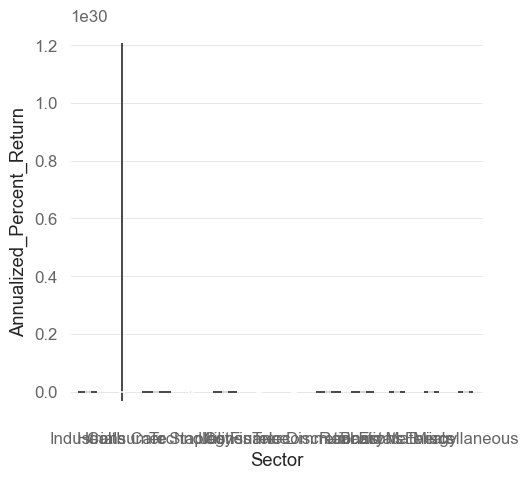

In [1503]:
sns.catplot(data=trading_history_obj.trades,kind='violin',x='Sector',y='Annualized_Percent_Return')

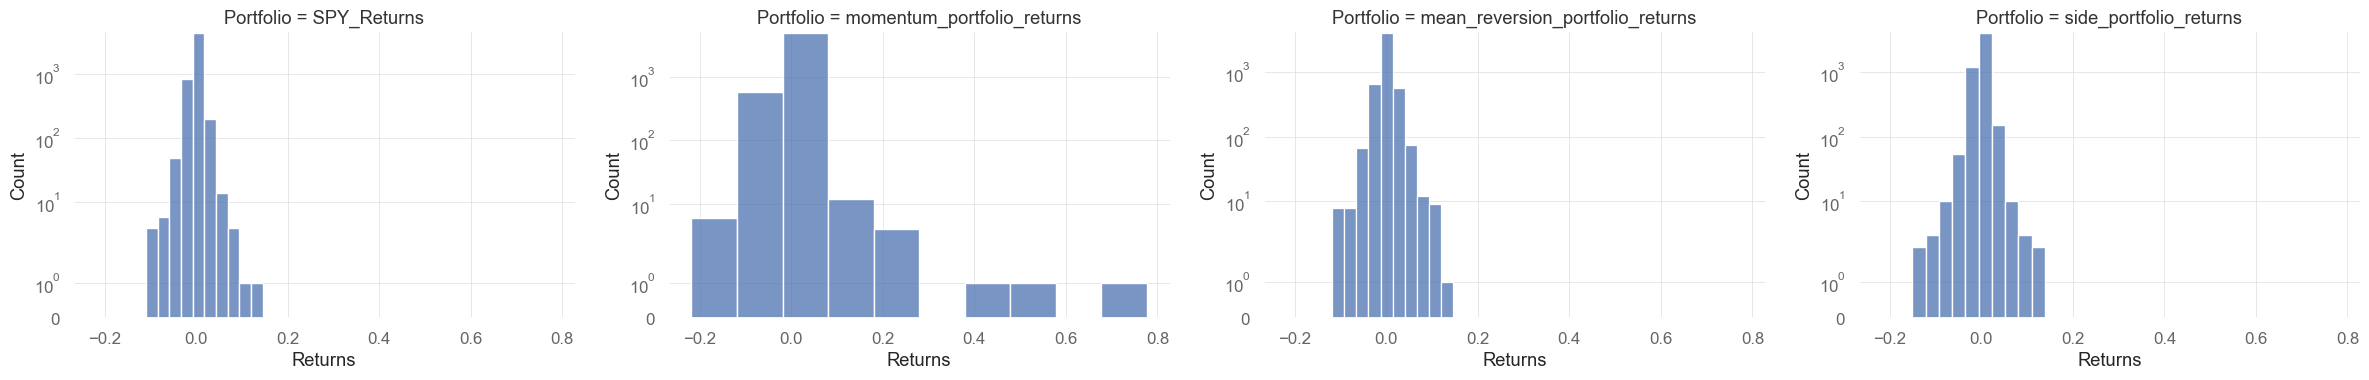

In [1504]:
# return daily return frequency
g = sns.FacetGrid(historical_performance_benchmark_just_returns.melt(var_name='Portfolio',value_name='Returns'), col="Portfolio", sharey=False, height=4, aspect=1.5)
g.map(sns.histplot, "Returns", bins=10)
g.set(yscale='symlog')

In [1505]:
trades = trading_history_obj.trades#.melt(var_name='Portfolio',value_name='Annualized_Percent_Return')
# sns.FacetGrid

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Industrials'),
  Text(1, 0, 'Health Care'),
  Text(2, 0, 'Consumer Staples'),
  Text(3, 0, 'Technology'),
  Text(4, 0, 'Utilities'),
  Text(5, 0, 'Finance'),
  Text(6, 0, 'Consumer Discretionary'),
  Text(7, 0, 'Telecommunications'),
  Text(8, 0, 'Real Estate'),
  Text(9, 0, 'Basic Materials'),
  Text(10, 0, 'Energy'),
  Text(11, 0, 'Miscellaneous')])

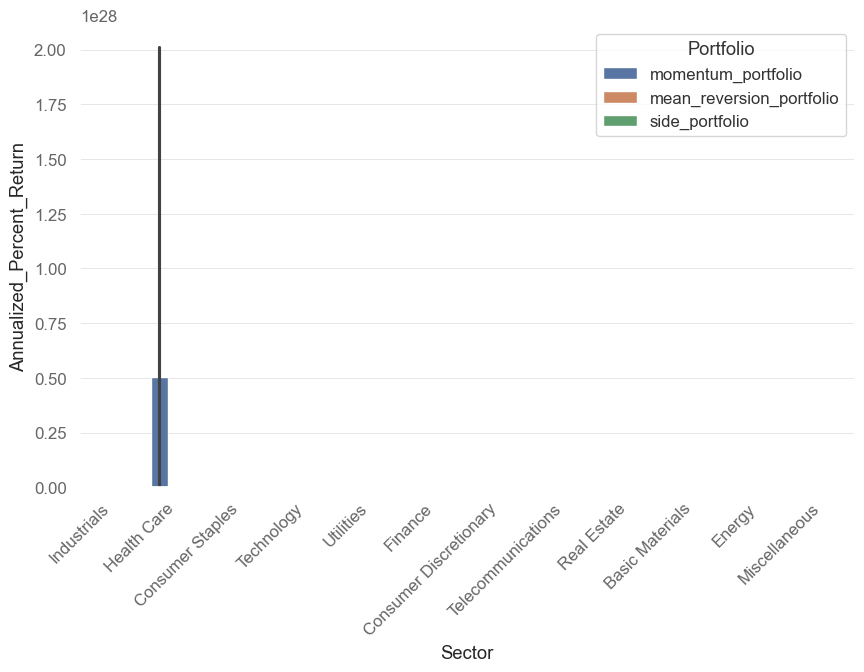

In [1506]:
g = sns.barplot(data=trading_history_obj.trades,x='Sector',y='Annualized_Percent_Return', hue='Portfolio',estimator='mean')
plt.xticks(rotation=45, ha="right")


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Industrials'),
  Text(1, 0, 'Health Care'),
  Text(2, 0, 'Consumer Staples'),
  Text(3, 0, 'Technology'),
  Text(4, 0, 'Utilities'),
  Text(5, 0, 'Finance'),
  Text(6, 0, 'Consumer Discretionary'),
  Text(7, 0, 'Telecommunications'),
  Text(8, 0, 'Real Estate'),
  Text(9, 0, 'Basic Materials'),
  Text(10, 0, 'Energy'),
  Text(11, 0, 'Miscellaneous')])

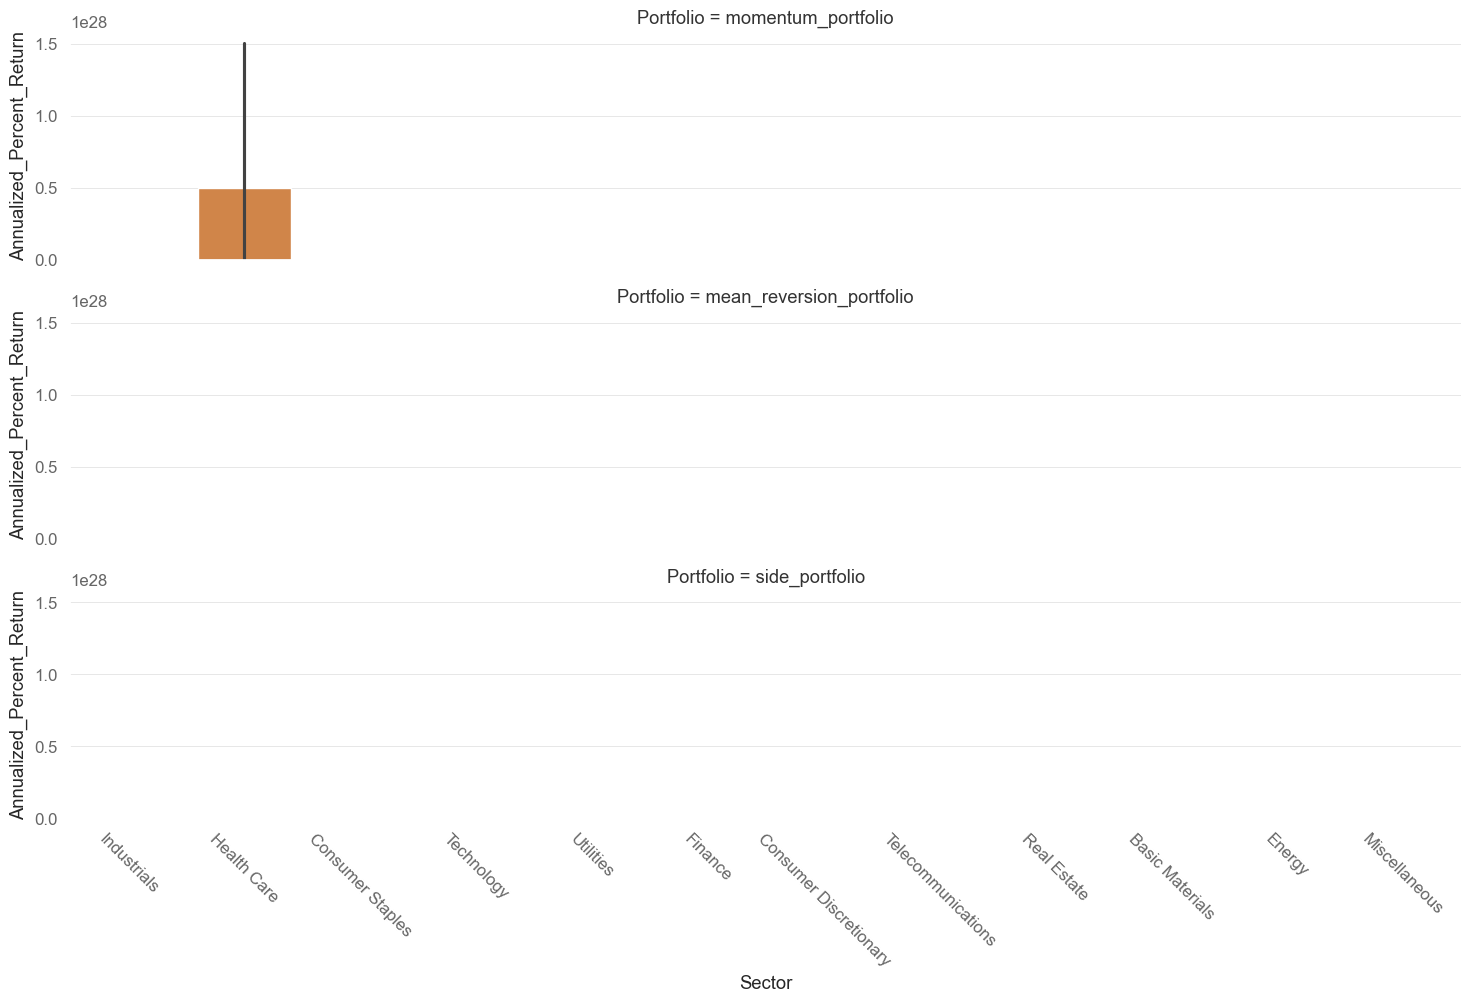

In [1507]:
g = sns.FacetGrid(data=trading_history_obj.trades, row='Portfolio',hue='Sector',aspect=5)
g.map(sns.barplot, 'Sector','Annualized_Percent_Return')
plt.xticks(rotation=-45)

In [1508]:
trading_history_obj.trades

Ticker Entry_Date  Entry_Share_Price  Entry_Trading_Cost  \
MT_2003-01-02       MT 2003-01-02           5.057238               0.005   
TXT_2003-01-02     TXT 2003-01-02          18.914682               0.005   
EXEL_2003-01-02   EXEL 2003-01-02           7.600000               0.005   
SJM_2003-01-02     SJM 2003-01-02          22.759865               0.005   
GEG_2003-01-02     GEG 2003-01-02          79.559998               0.005   
...                ...        ...                ...                 ...   
IP_2024-09-05       IP 2024-09-05          47.520000               0.002   
SAN_2024-09-11     SAN 2024-09-11           4.750000               0.002   
QXO_2024-09-16     QXO 2024-09-16          13.750000               0.005   
NVEI_2024-09-18   NVEI 2024-09-18          33.400002               0.005   
HCP_2024-09-23     HCP 2024-09-23          33.820000               0.005   

                   Shares  Exit_Date Exit_Share_Price Exit_Trading_Cost  \
MT_2003-01-02     18237.0 2004-01-05        20.957928             0.002   
TXT_2003-01-02     4876.0 2004-01-05        24.859852             0.005   
EXEL_2003-01-02   12135.0 2004-01-05             6.82              0.01   
SJM_2003-01-02     4052.0 2004-01-05        25.848949             0.005   
GEG_2003-01-02     1159.0 2004-01-05       140.279999             0.005   
...                   ...        ...              ...               ...   
IP_2024-09-05     14190.0 2024-09-27        49.040001             0.002   
SAN_2024-09-11   313336.0 2024-09-27             5.14             0.002   
QXO_2024-09-16   189331.0 2024-09-27            15.73             0.005   
NVEI_2024-09-18     347.0 2024-09-27            33.34             0.005   
HCP_2024-09-23      149.0 2024-09-27        33.900002             0.005   

                 Indicator High_Water_Share_Price High_Water_Date  \
MT_2003-01-02   -11.522947           92228.842569      2003-01-02   
TXT_2003-01-02   -6.252487           92227.991325      2003-01-02   
EXEL_2003-01-02  -6.083086           92225.998843      2003-01-02   
SJM_2003-01-02   -5.783261           92222.972198      2003-01-02   
GEG_2003-01-02   -5.781494            92210.03717      2003-01-02   
...                    ...                    ...             ...   
IP_2024-09-05    -0.002586          674308.806496      2024-09-05   
SAN_2024-09-11    0.003797              1488346.0      2024-09-11   
QXO_2024-09-16   15.851418             2603301.25      2024-09-16   
NVEI_2024-09-18 -14.921893           11589.800529      2024-09-18   
HCP_2024-09-23  -17.661510            5039.179955      2024-09-23   

                Low_Water_Share_Price Low_Water_Date  \
MT_2003-01-02                4.897777     2003-01-06   
TXT_2003-01-02              11.425323     2003-03-24   
EXEL_2003-01-02                  5.17     2003-03-12   
SJM_2003-01-02              18.971533     2003-03-14   
GEG_2003-01-02              41.400002     2003-02-12   
...                               ...            ...   
IP_2024-09-05               47.060001     2024-09-10   
SAN_2024-09-11                   4.75     2024-09-11   
QXO_2024-09-16                  13.75     2024-09-16   
NVEI_2024-09-18             33.299999     2024-09-20   
HCP_2024-09-23                  33.82     2024-09-23   

                                Portfolio  Days_Held         Return  \
MT_2003-01-02          momentum_portfolio        368  289980.884966   
TXT_2003-01-02         momentum_portfolio        368   28988.646233   
EXEL_2003-01-02        momentum_portfolio        368    -9465.29676   
SJM_2003-01-02         momentum_portfolio        368   12516.970901   
GEG_2003-01-02         momentum_portfolio        368   70374.481415   
...                                   ...        ...            ...   
IP_2024-09-05              side_portfolio         22   21568.806496   
SAN_2024-09-11             side_portfolio         16  122200.998165   
QXO_2024-09-16   mean_reversion_portfolio         11  374875.

In [1509]:
# g = sns.barplot(x='Sector',y='Annualized_Percent_Return',fac='Portfolio', data=trading_history_obj.trades)
# g = sns.catplot(data=trading_history_obj.trades,x='Sector',col='Portfolio',y='Annualized_Percent_Return', kind='bar')

# plt.xticks(rotation=90)
# plt.show
# sns.displot(data=trading_history_obj.trades,x='Sector',y='Annualized_Percent_Return',col='Portfolio')
# plt.xticks(rotation=45)

In [1510]:
average_returns_by_sector_size = trading_history_obj.trades.groupby(['Portfolio','Sector','Size_Category_Entry'])['Annualized_Percent_Return'].agg(['mean','min', 'max','std','count'])# .mean()
# average_returns_by_sector[average_returns_by_sector['Size_Category_Entry']=='mega']# or average_returns_by_sector['Size_Category_Entry']=='large']
display(average_returns_by_sector_size.sort_values(['Portfolio','mean']))

mean  \
Portfolio                Sector             Size_Category_Entry             
mean_reversion_portfolio Real Estate        large               -0.430637   
                         Energy             mid                 -0.077579   
                         Miscellaneous      mid                 -0.041417   
                         Finance            large                -0.00684   
                                            mid                  0.003637   
...                                                                   ...   
side_portfolio           Health Care        mega                  0.21704   
                         Telecommunications mid                  0.218129   
                         Utilities          mid                  0.256095   
                         Technology         mid                  0.288092   
                                            mega                 0.291429   

                                                                      min  \
Portfolio                Sector             Size_Category_Entry             
mean_reversion_portfolio Real Estate        large               -0.952268   
                         Energy             mid                 -0.933268   
                         Miscellaneous      mid                   -0.6513   
                         Finance            large               -0.999986   
                                            mid                      -1.0   
...                                                                   ...   
side_portfolio           Health Care        mega                -0.041923   
                         Telecommunications mid                 -0.348565   
                         Utilities          mid                 -0.640441   
                         Technology         mid                 -0.811877   
                                            mega                 0.291429   

                                                                      max  \
Portfolio                Sector             Size_Category_Entry             
mean_reversion_portfolio Real Estate        large                0.169401   
                         Energy             mid                  0.665758   
                         Miscellaneous      mid                  0.506397   
                         Finance            large                1.778905   
                                            mid                  1.680108   
...                                                                   ...   
side_portfolio           Health Care        mega                 0.476003   
                         Telecommunications mid                  0.570691   
                         Utilities          mid                   5.91912   
                         Technology         mid                  2.626265   
                                            mega                 0.291429   

                                                                      std  \
Portfolio                Sector             Size_Category_Entry             
mean_reversion_portfolio Real Estate        large                0.500994   
                         Energy             mid                  0.484014   
                         Miscellaneous      mid                  0.421762   
                         Finance            large                0.580548   
                                            mid                  0.416464   
...                                                                   ...   
side_portfolio           Health Care        mega                 0.366229   
                         Telecommunications mid                  0.287921   
                         Utilities          mid                  0.849485   
                         Technology         mid                  0.578097   
                                            mega                      NaN   

                                                             

In [1511]:
average_returns_by_industry = trading_history_obj.trades.groupby(['Country'])['Annualized_Percent_Return'].agg(['mean','min', 'max','std','count'])
pd.set_option('display.max_rows',150)
# display(average_returns_by_industry.sort_values(['mean']))
filtered_data = average_returns_by_industry[average_returns_by_industry['count'] > 5]
display(filtered_data.sort_values(['mean']))

mean       min  \
Country                                                     
France                                -0.189581 -0.594312   
Colombia                              -0.177429 -0.624144   
Greece                                -0.159647 -0.999999   
Argentina                             -0.088132 -0.841599   
Germany                                -0.03838  -0.91512   
Finland                               -0.034779 -0.328559   
Ireland                               -0.018996 -0.999483   
China                                 -0.006078      -1.0   
South Africa                           0.002352 -0.681988   
Peru                                   0.048582 -0.652883   
Canada                                 0.052102 -0.999974   
Indonesia                              0.075155 -0.120025   
India                                  0.095113 -0.496856   
Bermuda                                0.099799 -0.378982   
United Kingdom                         0.120878      -1.0   
Cayman Islands                         0.121537  -0.40546   
South Korea                            0.135433 -0.242963   
Switzerland                            0.140949 -0.612031   
Japan                                  0.143368 -0.587215   
Guernsey                                0.14985 -0.078742   
Chile                                  0.167261 -0.235726   
Taiwan                                 0.245289  -0.21479   
Australia                              0.262416 -0.371942   
Mexico                                  0.29339  -0.22908   
Netherlands                            0.296981 -0.461166   
Brazil                                 0.352511 -0.510022   
United States                          0.373445      -1.0   
Luxembourg                              0.60702 -0.822565   
Spain                                  0.770394 -0.193454   
New Zealand                         1625.706892 -0.999998   
Israel          73494441755965193509150916608.0 -0.797613   

                                              max           std  count  
Country                                                                 
France                                   0.109743  1.715186e-01     17  
Colombia                                 0.192117  3.081429e-01      8  
Greece                                   0.209803  4.271139e-01     13  
Argentina                                0.570691  4.355612e-01     12  
Germany                                   0.45137  4.095676e-01     14  
Finland                                  0.284629  1.784692e-01     10  
Ireland                                  0.781632  5.113509e-01     44  
China                                    2.823288  9.130356e-01     65  
South Africa                             0.940278  5.248276e-01     15  
Peru                                     0.945376  5.423666e-01      7  
Canada                                   1.238314  3.979235e-01    153  
Indonesia                                0.303817  1.677543e-01      7  
India                                    1.124811  3.782398e-01     27  
Bermuda                                  0.842239  2.608243e-01     28  
United Kingdom                            1.24023  3.833573e-01    115  
Cayman Islands                           1.045167  4.622774e-01     12  
South Korea                              1.008265  3.765733e-01     13  
Switzerland                              1.160217  3.670883e-01     29  
Japan                                    0.782023  3.863958e-01     20  
Guernsey                                 0.369808  1.537894e-01      6  
Chile                                    0.863604  3.229370e-01     14  
Taiwan                                   1.817111  5.250752e-01     13  
Australia                                1.554041  6.745794e-01      8  
Mexico                                   1.448531  3.514012e-01     24  
Netherlands                              1.532695  4.221183e-01     27  
Brazil                                    5.91912  9.64148

In [1512]:
company_data.value_counts('Sector')

Sector
Finance                   1522
Consumer Discretionary    1159
Health Care               1158
Technology                 752
Industrials                561
Real Estate                277
Energy                     183
Utilities                  174
Consumer Staples           145
Telecommunications         103
Basic Materials             87
Miscellaneous               63
Name: count, dtype: int64

In [1513]:
company_data.value_counts('Industry')

Industry
Biotechnology: Pharmaceutical Preparations                        574
Major Banks                                                       308
Computer Software: Prepackaged Software                           258
Real Estate Investment Trusts                                     219
Industrial Machinery/Components                                   213
Blank Checks                                                      202
Investment Managers                                               191
Biotechnology: Biological Products (No Diagnostic Substances)     185
EDP Services                                                      171
Finance: Consumer Services                                        168
Medical/Dental Instruments                                        129
Business Services                                                 119
Trusts Except Educational Religious and Charitable                115
Oil & Gas Production                                              107
Semiconduct

In [1514]:
company_data['Sector'].unique()

array(['Industrials', 'Real Estate', 'Finance', 'Health Care',
       'Consumer Discretionary', nan, 'Technology', 'Basic Materials',
       'Consumer Staples', 'Energy', 'Miscellaneous', 'Utilities',
       'Telecommunications'], dtype=object)

In [1515]:
['Finance', 'Consumer Discretionary', 'Health Care', 'Technology', 'Industrials', 'Real Estate', 'Energy', 'Utilities', 'Consumer Staples', 'Telecommunications', 'Basic Materials', 'Miscellaneous']

['Finance',
 'Consumer Discretionary',
 'Health Care',
 'Technology',
 'Industrials',
 'Real Estate',
 'Energy',
 'Utilities',
 'Consumer Staples',
 'Telecommunications',
 'Basic Materials',
 'Miscellaneous']